<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_lectures/blob/main/Lecture_2_2_16_%D0%92%D0%B8%D1%80%D1%96%D1%88%D0%B5%D0%BD%D0%BD%D1%8F_%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B8_%D0%B4%D0%B8%D1%81%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D1%83_%D0%BA%D0%BB%D0%B0%D1%81%D1%96%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Стратегії вирішення проблеми дисбалансу класів
==========================================================================

В цьому уроці ми розберемось, що таке random undersampling, oversampling, методи SMOTE, ADASYN та зв'язки Томека для балансування класів.


![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*Qn9_yFLYCZIQXFwf)


# Вступ

Дисбаланс класів виникає, коли один клас у задачі класифікації значно переважає інший клас. Це поширене явище у багатьох задачах машинного навчання. Прикладами є виявлення шахрайства, виявлення аномалій та медична діагностика захворювань.

## Прокляття дисбалансу класів

Модель, навчена на дисбалансованому наборі даних, погано працює з мінорним класу. У кращому випадку це може призвести до втрат для бізнесу у випадку аналізу відтоку клієнтів. У гіршому випадку це може призвести до системної упередженості в системі розпізнавання облич чи виявлення, чи в пацієнта є хвороба.

Найбільш поширений підхід до вирішення проблеми дисбалансу класів — це ресемплінг. Це може включати oversampling (збільшення кількості екземплярів) меншинного класу, undersampling (зменшення кількості екземплярів) множинного класу або комбінацію обох. Але робити ми це можемо різними методами.

В цьому уроці ми на реальному наборі даних розглянемо різні стратегії ресамплінгу:

1.  Random oversampling
2.  Random undersampling
3.  Oversampling за допомогою SMOTE
4.  Oversampling за допомогою ADASYN
5.  Undersampling за допомогою зв'язків Томека
6.  Oversampling за допомогою SMOTE, потім Undersampling за допомогою зв'язків Томека (SMOTE-Tomek)

І звісно ми оцінимо вплив кожної стратегії на модель машинного навчання. Поїхали.



# Використання Imbalance-learn

Ми будемо використовувати пакет `imbalanced-learn` у Python для вирішення нашої проблеми дисбалансу класів. Це бібліотека з відкритим вихідним кодом, яка базується на scikit-learn і надає інструменти для роботи з класифікацією з дисбалансованими класами.

Встановлюємо через pip наступним чином:

In [1]:
!pip install -U imbalanced-learn

Набір даних
==========

Набір даних, який ми використовуємо, це [**Communities and Crime Data Set by UCI (CC BY 4.0)**.](https://archive.ics.uci.edu/ml/datasets/communities+and+crime) Він містить 100 атрибутів для 1994 спільнот США. Ми можемо використовувати його для прогнозування, чи є **рівень злочинності високим** (визначається як **кількість насильницьких злочинів на душу населення** понад 0.65). Джерело даних доступне в UCI Machine Learning Repository і створене Майклом Редмондом з Університету Ла Саль (опубліковано в 2009 році).

> Змінні, включені в датасет, охоплюють як характеристики спільноти, такі як відсоток населення, яке вважається міським, та медіанний дохід сім'ї, так і характеристики правоохоронних органів, такі як кількість поліцейських на душу населення та відсоток офіцерів, призначених до підрозділів по боротьбі з наркотиками.

Цей набір даних є незбалансованим. Він має 12 спільнот з низьким рівнем злочинності на кожну 1 спільноту з високим рівнем злочинності. Це ідеально підходить для ілюстрації нашого випадку використання методів боротьби з дисбалансом класів.

In [2]:
from imblearn.datasets import fetch_datasets

# Fetch dataset from imbalanced-learn library
# as a dictionary of numpy array
us_crime = fetch_datasets()['us_crime']
us_crime

{'data': array([[0.19, 0.33, 0.02, ..., 0.26, 0.2 , 0.32],
        [0.  , 0.16, 0.12, ..., 0.12, 0.45, 0.  ],
        [0.  , 0.42, 0.49, ..., 0.21, 0.02, 0.  ],
        ...,
        [0.16, 0.37, 0.25, ..., 0.32, 0.18, 0.91],
        [0.08, 0.51, 0.06, ..., 0.38, 0.33, 0.22],
        [0.2 , 0.78, 0.14, ..., 0.3 , 0.05, 1.  ]]),
 'target': array([-1,  1, -1, ..., -1, -1, -1]),
 'DESCR': 'us_crime'}

Ми перетворимо цей словник на Pandas dataframe, а потім розділимо його на навчальні та тестові набори.

In [3]:
import pandas as pd

crime_df = pd.concat([
      pd.DataFrame(us_crime['data'], columns = [f'data_{i}' for i in range(us_crime.data.shape[1])]),
      pd.DataFrame(us_crime['target'], columns = ['target'])
    ], axis = 1)

In [4]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, data_0 to target
dtypes: float64(100), int64(1)
memory usage: 1.5 MB


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(crime_df.drop('target', axis = 1),
                                                    crime_df['target'],
                                                    test_size = 0.4,
                                                    random_state = 42,
                                                    stratify=crime_df['target']
                                                    )

In [7]:
crime_df['target'].value_counts()

,count
target,
-1,1844
1,150


Зверніть увагу, що ми будемо виконувати недо- та пересемплінг лише на навчальному наборі даних. **Ми _не_ будемо змінювати тестові набори за допомогою недо- та пересемплінгу.** В робочих проєктах теж ми так не будемо робити :)

Попередня обробка набору даних
-------------------------

Наша мета — візуалізувати незбалансований набір даних. Щоб візуалізувати 128-вимірний набір даних на 2D графіку, ми виконуємо наступне на навчальному наборі:

*   масштабуємо набір даних,
*   виконуємо аналіз головних компонент (PCA) на ознаках, щоб перетворити 100 ознак на 2 головні компоненти,
*   візуалізуємо дані.

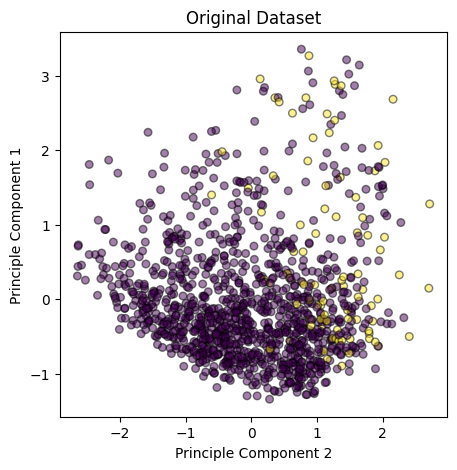

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
# Note that we fit PCA on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Function for plotting dataset
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

Завершивши попередню обробку, ми готові до оверсамплінгу нашого набору даних.

Стратегія 1. Random oversampling
======================================

Random oversampling дублює існуючі приклади з мінорного класу з поверненням. Кожна точка даних у меншості має однакову ймовірність бути дубльованою.

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*_asVR8BHEJUItC3lO0n8Ug.png)

Ось як ми можемо виконати надвибіркування на нашому наборі даних.

In [9]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train_pca, y_train)

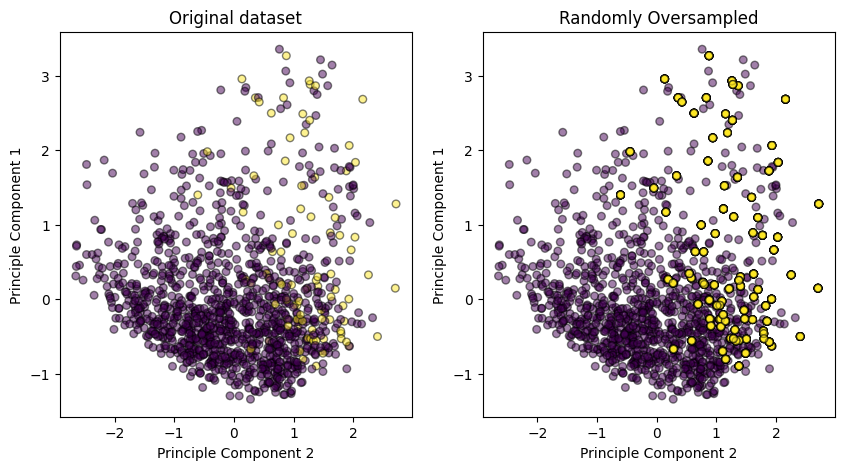

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
plot_data(X_train_pca, y_train, ax[0], 'Original dataset')
plot_data(X_train_ros, y_train_ros, ax[1], 'Randomly Oversampled')

In [11]:
y_train.value_counts()

,count
target,
-1,1106
1,90


In [12]:
y_train_ros.value_counts()

,count
target,
-1,1106
1,1106


Порівняймо дані до (ліворуч) і після (праворуч) random oversampling .

Єдина різниця? Після random oversampling з'являється більше **перекриваючихся точок даних мінорного класу**. В результаті точки даних меншинного класу виглядають темнішими.

**Стратегія 2. Random undersampling**
========================================

Навпаки, random undersampling видаляє існуючі зразки з множинного класу. Кожна точка даних у множинному класы має рівний шанс бути видаленою.

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*gn1-qFVwRy7xH98nQr9Giw.png)

Ми можемо зробити це за допомогою наступного коду.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)

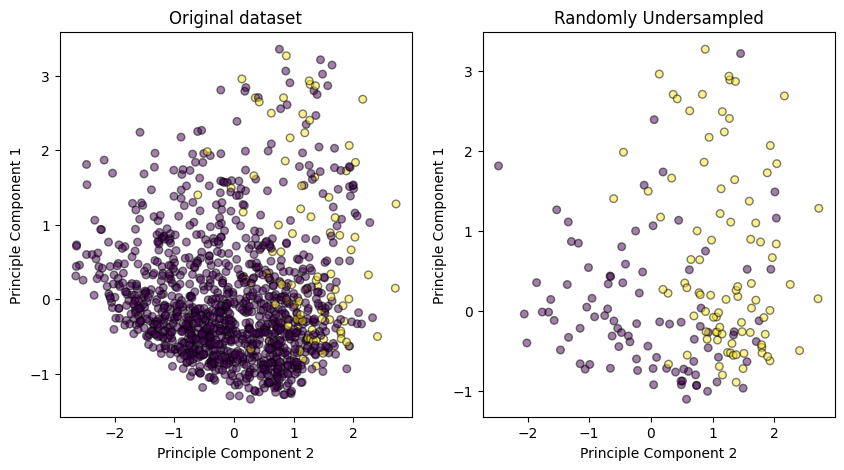

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
plot_data(X_train_pca, y_train, ax[0], 'Original dataset')
plot_data(X_train_rus, y_train_rus, ax[1], 'Randomly Undersampled')

Давайте порівняємо дані до (ліворуч) і після (праворуч) випадкового зменшення вибірки.

Після зменшення вибірки загальна кількість точок даних значно зменшилася. Це тому, що точки даних у множинному класі видаляються випадковим чином, поки класи не стануть збалансованими.

## Застосування машинного навчання до undersampled, oversampled наборів даних

Давайте порівняємо продуктивність моделі машинного навчання для класифікації (модель SVM), навченої на трьох наборах даних (original, oversampled, undersampled).

Тут ми навчаємо три класифікатори опорних векторів (SVC) на трьох наборах даних:

*   Оригінальні дані
*   Randomly oversampled
*   Randomly undersampled

In [16]:
from sklearn.svm import SVC

# Train SVC on original data
clf = SVC(kernel='linear',probability=True)
clf.fit(X_train_pca, y_train)

# Train SVC on randomly oversampled data
clf_ros = SVC(kernel='linear',probability=True)
clf_ros.fit(X_train_ros, y_train_ros)

# Train SVC on randomly undersampled data
clf_rus = SVC(kernel='linear',probability=True)
clf_rus.fit(X_train_rus, y_train_rus)


SVC(kernel='linear', probability=True)

Тоді ми можемо візуалізувати, що кожен SVC навчився з набору даних.

In [17]:
import numpy as np

def plot_decision_boundaries(X, y, clf, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', s=20)
    ax.set_title(title)
    return scatter

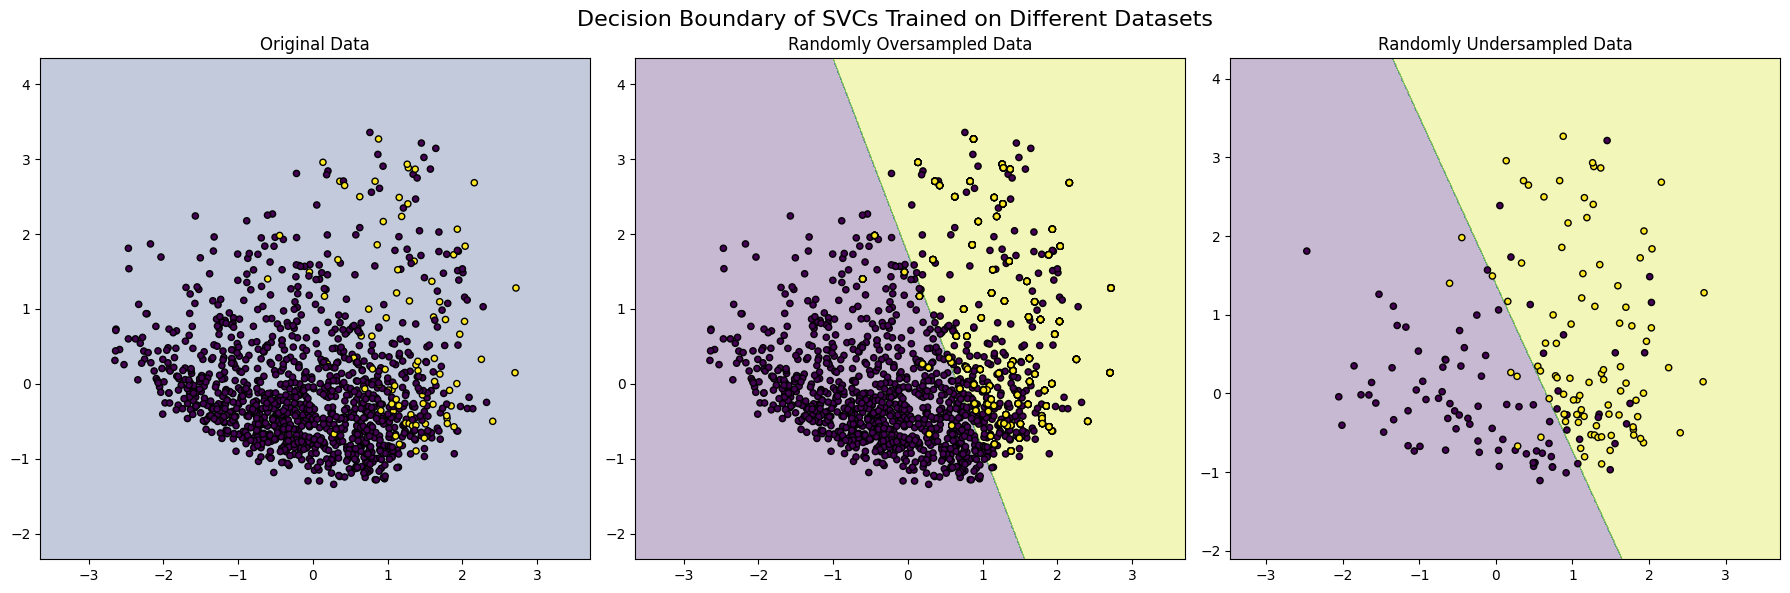

In [18]:
# Plot the decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_decision_boundaries(X_train_pca, y_train, clf, axes[0], "Original Data")
plot_decision_boundaries(X_train_ros, y_train_ros, clf_ros, axes[1], "Randomly Oversampled Data")
plot_decision_boundaries(X_train_rus, y_train_rus, clf_rus, axes[2], "Randomly Undersampled Data")

fig.suptitle('Decision Boundary of SVCs Trained on Different Datasets', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



Графіки вище підсумовують, чого алгоритми навчилися з набору даних. Зокрема, вони навчилися, що:

*   Нова точка, яка потрапляє в **жовту** область, прогнозується як **жовта** точка (‘_Спільнота з високим рівнем злочинності_’)
*   Нова точка, яка потрапляє в **фіолетову** область, прогнозується як **фіолетова** точка (‘_Спільнота з низьким рівнем злочинності_’)

Ось деякі спостереження:

*   SVC, навчений на _оригінальному_ наборі даних, є… досить безтолковим. Він фактично прогнозує всі спільноти як фіолетові. Він навчається ігнорувати всі жовті точки. Це тому що є дизбаланс класів.
*   SVC, навчені на наборах даних з oversampled та undersampled даних, менш упереджені. Вони менш схильні неправильно класифікувати мінорний клас.
*   Decision boundaries SVC, навчених на наборах даних з oversampled та undersampled даних, відрізняються.

Використання ROC для оцінки моделей з повторною вибіркою
--------------------------------------

Щоб оцінити, який SVC є найкращим, оцінимо якість SVC на тестовому наборі: виміряємо ROC AUC і побудуємо криву ROC.

In [19]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear',probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)


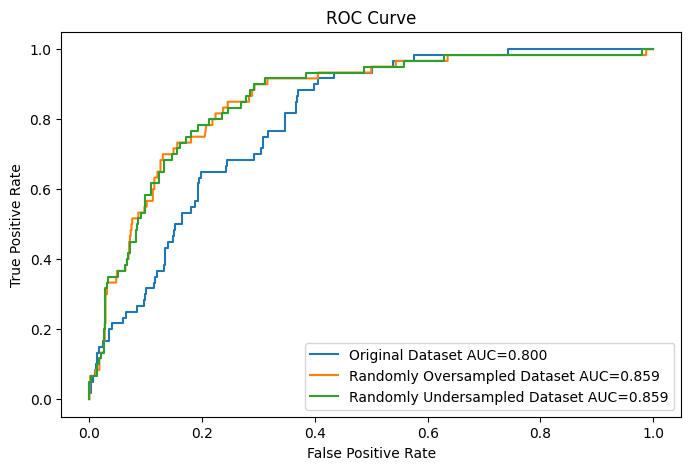

In [20]:
# Plot all ROC into one graph
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')


SVC, навчений на оригінальних даних, показав погані результати. Він працював незначно краще (auroc = 0.524), ніж якби ми випадково вгадували результат.

Randomly oversampled набір даних перевершив undersampled набір даних. Однією з можливих причин є втрата інформації при видаленні точок даних у процесі undersampling. І навпаки, при oversampling даних інформація не втрачається.

Тепер, коли ми розуміємо oversampling та undersampling, давайте заглибимося в техніки oversampling та undersampling.

Стратегія 3. Oversampling з SMOTE
================================

SMOTE (Synthetic Minority Oversampling Technique) — це метод oversampling. Інтуїтивно SMOTE створює синтетичні точки даних шляхом інтерполяції між точками даних мінорного класу, які знаходяться близько одна до одної.

Ось як працює SMOTE (спрощено).

1. Випадково виберіть деякі точки даних у класі меншості.
2. Для кожної вибраної точки визначте її _k_ найближчих сусідів.
3. Для кожного сусіда додайте нову точку десь між точкою даних і сусідом.
4. Повторюйте кроки 2-4, поки не буде створено достатню кількість синтетичних точок даних.

Відео-візуалізація як працює SMOTE
https://youtu.be/NvrfSntsm7w


Давайте зробимо oversampling нашому набору даних за допомогою SMOTE і навчимо на ньому SVC.

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC

# Perform random sampling
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

# Train linear SVC
clf_smote = SVC(kernel='linear',probability=True)
clf_smote.fit(X_train_smote, y_train_smote)

SVC(kernel='linear', probability=True)

In [22]:
X_train_pca

array([[-1.2600296 ,  0.7745444 ],
       [ 0.38899366,  0.42202391],
       [ 0.59159923,  0.35623004],
       ...,
       [-0.98241431,  0.86473067],
       [-1.74000792,  0.17965826],
       [ 1.61147417,  0.16004735]])

In [23]:
y_train_smote.value_counts()

,count
target,
-1,1106
1,1106


In [24]:
test = pd.DataFrame(X_train_smote)
test['target'] = y_train_smote
# .duplicated().sum()
# .duplicates().sum()

In [25]:
X_train_pca

array([[-1.2600296 ,  0.7745444 ],
       [ 0.38899366,  0.42202391],
       [ 0.59159923,  0.35623004],
       ...,
       [-0.98241431,  0.86473067],
       [-1.74000792,  0.17965826],
       [ 1.61147417,  0.16004735]])

In [26]:
original  = pd.DataFrame(X_train_pca)

In [27]:
test.merge(pd.DataFrame(X_train_pca), how='left', left_on=0, right_on=0).sort_values([0,'1_x'])

,0,1_x,target,1_y
982,-2.650084,0.313313,-1,0.313313
1029,-2.641175,0.441081,-1,0.441081
762,-2.638366,0.713754,-1,0.713754
458,-2.635872,0.730835,-1,0.730835
635,-2.587299,0.458860,-1,0.458860
...,...,...,...,...
2194,2.689775,1.303735,1,NaN
1323,2.691113,1.267756,1,NaN
1695,2.697805,0.155051,1,NaN
372,2.706206,0.149217,1,0.149217


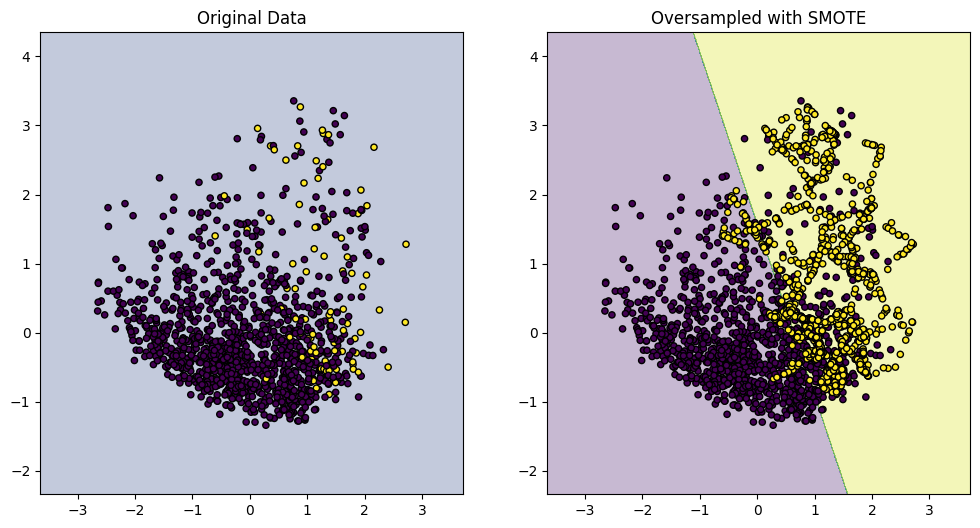

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_decision_boundaries(X_train_pca, y_train, clf, axes[0], "Original Data")
plot_decision_boundaries(X_train_smote, y_train_smote, clf_smote, axes[1], "Oversampled with SMOTE");


Стратегія 4. Oversampling з ADASYN (+ Як це відрізняється від SMOTE)
======================================================================

ADASYN (Adaptive Synthetic Sampling) є родичем SMOTE: як SMOTE, так і ADASYN генерують нові зразки шляхом інтерполяції.

Але є одна суттєва відмінність. ADASYN генерує зразки поруч з оригінальними зразками, які неправильно класифіковані класифікатором KNN. Натомість SMOTE розрізняє зразки, які правильно або неправильно класифіковані класифікатором KNN.

Відео-візуалізація того, як працює ADASYN: https://youtu.be/69CoxAoR3Gs

Як працює ADASYN:

1. **Обчислення різниці між класами**:
   - Спочатку обчислюється кількість прикладів у меншому класі (minority class) та більшому класі (majority class).
   - Визначається кількість синтетичних прикладів, які потрібно створити для меншого класу, щоб зменшити дисбаланс.

2. **Визначення важливості кожного прикладу меншого класу**:
   - Для кожного прикладу меншого класу обчислюється кількість його найближчих сусідів з більшого класу.
   - Важливість кожного прикладу меншого класу визначається на основі кількості сусідів з більшого класу. Приклади, які мають більше сусідів з більшого класу, вважаються більш важливими і для них буде створено більше синтетичних прикладів.

3. **Генерація синтетичних прикладів**:
   - Для кожного прикладу меншого класу генеруються синтетичні приклади. Кількість синтетичних прикладів для кожного прикладу пропорційна до його важливості.
   - Синтетичні приклади створюються шляхом лінійної інтерполяції між прикладом меншого класу та одним з його найближчих сусідів з меншого класу.
   - Новий синтетичний приклад обчислюється за формулою: $ \text{new_example} = x_i + \lambda (x_{i, nn} - x_i) $, де $ x_i $ — приклад меншого класу, $ x_{i, nn} $ — його випадковий найближчий сусід з меншого класу, а $ \lambda $ — випадкова величина в діапазоні [0, 1].

4. **Завершення процесу**:
   - Нові синтетичні приклади додаються до тренувального набору даних.
   - В результаті отримується більш збалансований тренувальний набір, що покращує продуктивність моделі на нерівномірно розподілених даних.

Псевдокод ADASYN виглядає наступним чином:

```python
from sklearn.neighbors import NearestNeighbors
import numpy as np

def adasyn(X, y, beta=1.0, k=5):
    # Розділення на більший та менший класи
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    n_minority = len(X_minority)
    n_majority = len(X_majority)

    # Визначення кількості синтетичних прикладів
    G = (n_majority - n_minority) * beta

    # Визначення важливості кожного прикладу меншого класу
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, indices = nn.kneighbors(X_minority)
    
    # Ваги для кожного прикладу меншого класу
    weights = np.sum(y[indices] == 0, axis=1)
    weights = weights / np.sum(weights)

    # Генерація синтетичних прикладів
    synthetic_samples = []
    for i in range(n_minority):
        for _ in range(int(G * weights[i])):
            nn_index = np.random.choice(indices[i][1:])
            diff = X_minority[nn_index] - X_minority[i]
            synthetic_sample = X_minority[i] + np.random.rand() * diff
            synthetic_samples.append(synthetic_sample)
    
    # Додавання синтетичних прикладів до набору даних
    X_synthetic = np.array(synthetic_samples)
    y_synthetic = np.ones(len(X_synthetic))

    X_resampled = np.vstack((X, X_synthetic))
    y_resampled = np.hstack((y, y_synthetic))

    return X_resampled, y_resampled
```

Цей псевдокод показує основні кроки ADASYN, включаючи обчислення ваги, генерацію синтетичних прикладів і об'єднання їх з оригінальним набором даних.


Давайте пересемпліруємо наш набір даних за допомогою ADASYN і навчимо на ньому SVC.

In [29]:
from imblearn.over_sampling import ADASYN

# Perform random sampling
adasyn = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_pca, y_train)

# Train linear SVC
from sklearn.svm import SVC
clf_adasyn = SVC(kernel='linear',probability=True)
clf_adasyn.fit(X_train_adasyn, y_train_adasyn)

SVC(kernel='linear', probability=True)

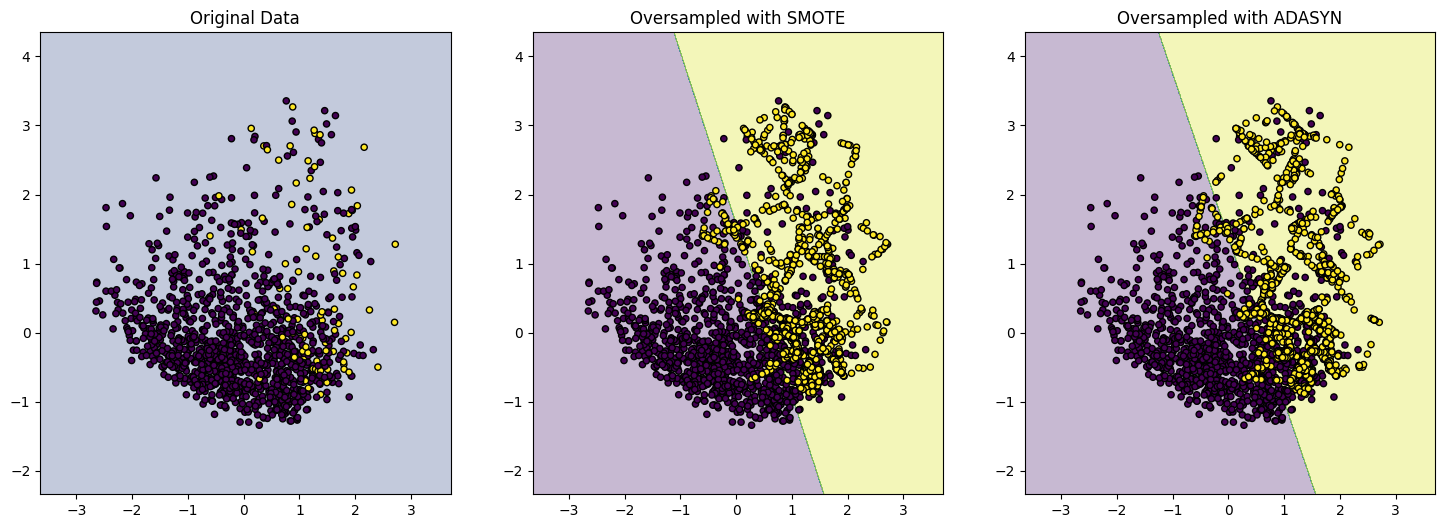

In [30]:
# Plot decision boundary
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_decision_boundaries(X_train_pca, y_train, clf, axes[0], "Original Data")
plot_decision_boundaries(X_train_smote, y_train_smote, clf_smote, axes[1], "Oversampled with SMOTE")
plot_decision_boundaries(X_train_adasyn, y_train_adasyn, clf_adasyn, axes[2], "Oversampled with ADASYN");


З візуалізації можемо зробити наступні спостереження.

По-перше, обидва підходи до oversampling призводять до створення більшої кількості синтетичних точок даних _між_ оригінальними точками даних. Це тому, що і SMOTE, і ADASYN використовують _інтерполяцію_ для створення нових точок даних.

По-друге, порівнюючи SMOTE і ADASYN, ми помічаємо, що ADASYN створює точки даних для меншоинного класу (_жовті_) поблизу точок даних множинного класу (_фіолетові_).

*   Порівнюючи області, обведені синім вище, ADASYN створив _менше_ жовтих точок даних в областях з лише кількома фіолетовими точками даних.
*   Порівнюючи області, обведені коричневим вище, ADASYN створив _більше_ жовтих точок даних в областях з більшою кількістю фіолетових точок даних.

Порівняймо ROC всіх методів oversampling, які ми описали до цього часу. У цьому прикладі вони працюють однаково добре.



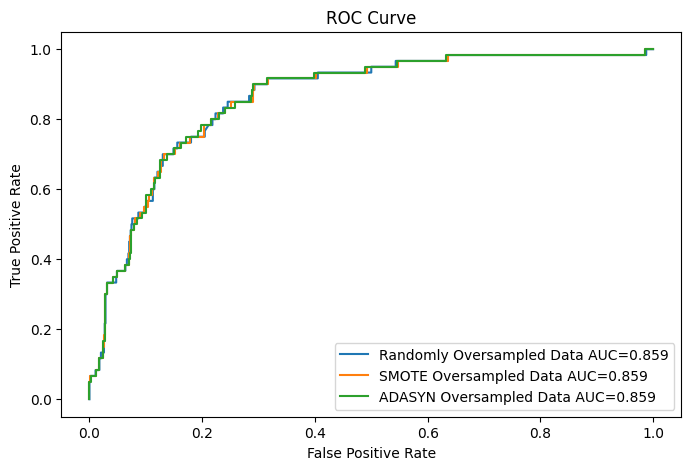

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Data')
plot_roc(ax, X_train_smote, y_train_smote, X_test_pca, y_test, 'SMOTE Oversampled Data')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test_pca, y_test, 'ADASYN Oversampled Data');




Стратегія 5. Undersampling з використанням зв'язків  (Tomek Links)
========================================================

Зв'язок Томека — це пара точок, які дуже близькі одна до одної, але належать до різних класів.

Математичне визначення зв'язку Томека:

- Задаючи два екземпляри Ei та Ej, які належать до різних класів, та d(Ei, Ej), що є відстанню між Ei та Ej, пара (Ei, Ej) називається звʼязком Томека, якщо не існує прикладу El, такого що d(Ei, El) < d(Ei, Ej) або d(Ej, El) < d(Ei, Ej).

Відео-візуалізація: https://youtu.be/IIj6J0TW-nw

Щоб виконати undersampling з використанням зв'язків Томека, ми визначаємо всі зв'язки Томека в наборі даних. Для кожної пари точок даних у зв'язку Томека ми видалимо точку даних з більшого класу.

Ми застосуємо undersampling з використанням зв'язку Томека до нашого набору даних і порівняємо метод Tomek undersampling з випадковим undersampling.

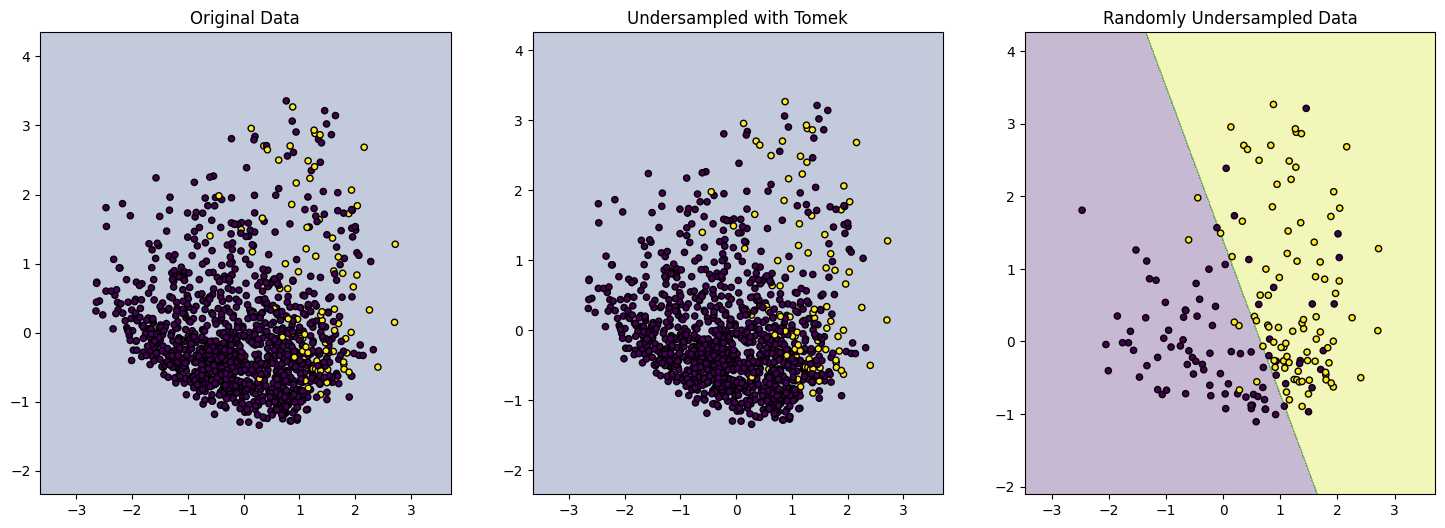

In [32]:
from imblearn.under_sampling import TomekLinks
from sklearn.svm import LinearSVC

# Perform Tomek Link undersampling
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_pca, y_train)

# Train linear SVC
clf_tomek = SVC(kernel='linear',probability=True)
clf_tomek.fit(X_train_tomek, y_train_tomek)

# Plot decision boundary
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_decision_boundaries(X_train_pca, y_train, clf, axes[0], "Original Data")
plot_decision_boundaries(X_train_tomek, y_train_tomek, clf_tomek, axes[1], "Undersampled with Tomek")
plot_decision_boundaries(X_train_rus, y_train_rus, clf_rus, axes[2], "Randomly Undersampled Data");




У нашому конкретному наборі даних видалення з Tomek Link мало що змінило в дисбалансі класів. Це тому, що в наборі даних обмежена кількість Tomek Links.

Давайте подивимося, як якість undersampling з Tomek Link відрізняється від випадкового undersampling.



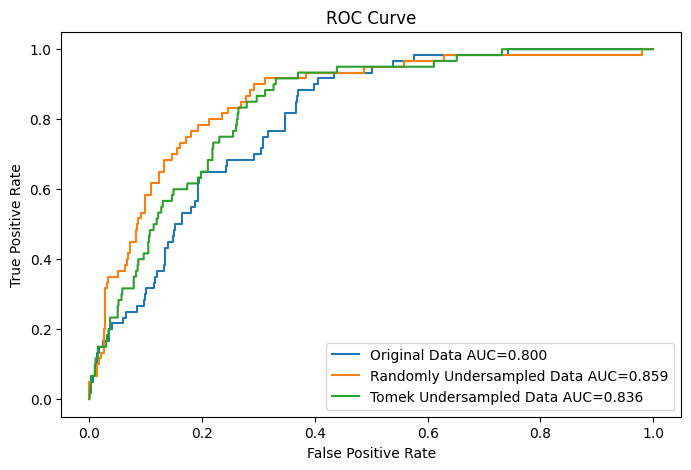

In [33]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Data')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Data')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test_pca, y_test, 'Tomek Undersampled Data');


Ми спостерігаємо, що **випадковий undersampling показав кращі результати, ніж Tomek Link undersampling.** Це тому, що Tomek Link не усунув дисбаланс класів повністю, як це зробив випадковий undersampling.

Стратегія 6. SMOTEK: Oversample з SMOTE, потім Undersample з Tomek Links
============================================================================

Тепер, коли ми дізналися про oversampling і undersampling, нас цікавить чи=и можемо ми поєднати ці техніки?

Звичайно! **SMOTE-TOMEK** — це техніка, яка поєднує oversampling (SMOTE) з undersampling (з Tomek Links).

Ми застосуємо її до нашого набору даних.
А потім порівняємо SMOTE, Tomek та SMOTE-Tomek.

In [34]:
from imblearn.combine import SMOTETomek
from sklearn.svm import LinearSVC

smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_pca, y_train)

clf_smotetomek = SVC(kernel='linear',probability=True)
clf_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)


SVC(kernel='linear', probability=True)

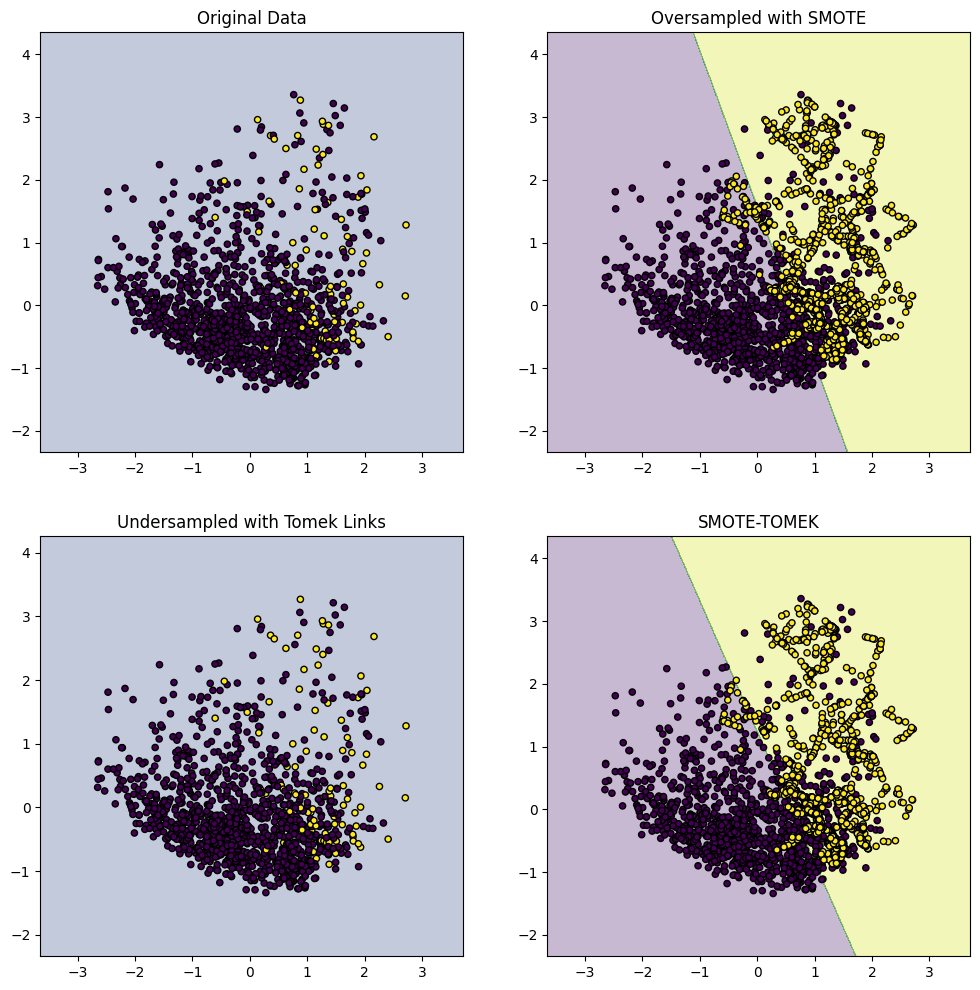

In [35]:
# Plot decision boundary
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plot_decision_boundaries(X_train_pca, y_train, clf, axes[0][0], "Original Data")
plot_decision_boundaries(X_train_smote, y_train_smote, clf_smote, axes[0][1], "Oversampled with SMOTE")
plot_decision_boundaries(X_train_tomek, y_train_tomek, clf_tomek, axes[1][0], "Undersampled with Tomek Links")
plot_decision_boundaries(X_train_smotetomek, y_train_smotetomek, clf_smotetomek, axes[1][1], "SMOTE-TOMEK");

Порівнюючи SMOTE-Tomek з лише SMOTE, ми бачимо наступну різницю: SMOTE-Tomek видаляє точки, які знаходяться близько до межі.

Для великого фіналу ми порівняємо всі техніки, які ми описали вище. SMOTE показав найкращий результат.



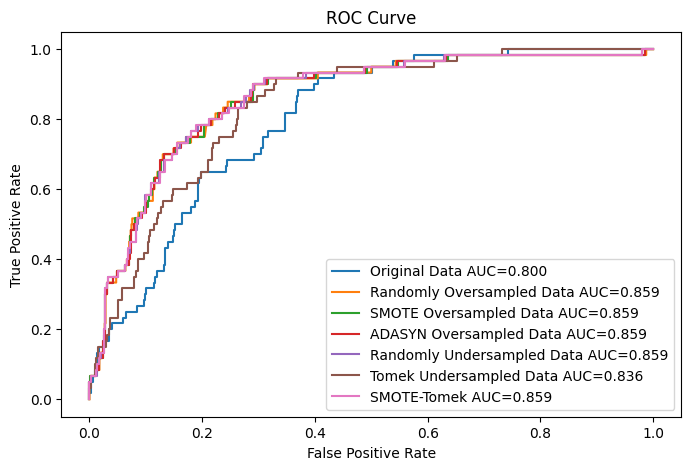

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Data')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Data')
plot_roc(ax, X_train_smote, y_train_smote, X_test_pca, y_test, 'SMOTE Oversampled Data')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test_pca, y_test, 'ADASYN Oversampled Data')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Data')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test_pca, y_test, 'Tomek Undersampled Data')
plot_roc(ax, X_train_smotetomek, y_train_smotetomek, X_test_pca, y_test, 'SMOTE-Tomek');




Заключення
==========

Загалом, ви можете використовувати оверсемплінг, андерсемплінг або їх комбінацію для вирішення проблеми дисбалансу даних.
Загальні **рекомендації**:

- якщо у вас є обчислювальні ресурси, часто краще використовувати комбінацію оверсемплінгу та андерсемплінгу;
- оверсемплінг є хорошою стратегією, коли у вас мало даних;
- тоді як андерсемплінг підходить, коли є потенційно багато схожих даних.

Робота з дисбалансованими наборами даних не є легкою. Я рекомендую вам дослідити інші стратегії ресемплінгу (включаючи різні [методи андерсемплінгу](https://imbalanced-learn.org/dev/references/under_sampling.html) та [методи оверсемплінгу](https://imbalanced-learn.org/dev/references/over_sampling.html)), щоб побачити, яка стратегія найкраще підходить для вашого набору даних в кожному конкретному випадку.

Також, вимірювання якості на дисбалансованих наборах даних може бути складним. Переконайтеся, що ви використовуєте правильні метрики класифікації. На щастя, ми з вами вже знайомі з такими метриками як [ROC-крива](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) та [F1-оцінка](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). Ознайомтесь також з [геометричними середніми оцінками](https://imbalanced-learn.org/dev/references/metrics.html).


Додаткові матеріали
-------------------------------------------

[1] Batista, Gustavo EAPA, Ronaldo C. Prati, and Maria Carolina Monard. “[A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data](https://www.researchgate.net/publication/220520041_A_Study_of_the_Behavior_of_Several_Methods_for_Balancing_machine_Learning_Training_Data)” _ACM SIGKDD explorations newsletter_ 6.1 (2004): 20–29.

[2] Chawla, Nitesh V., et al. “[SMOTE: synthetic minority over-sampling technique.](https://dl.acm.org/doi/10.5555/1622407.1622416)” _Journal of artificial intelligence research_ 16 (2002): 321–357.